In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datatable as dt
import tensorflow as tf
from tensorflow import keras
from warnings import filterwarnings
filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
### set seeds
my_seed = 1

np.random.seed(my_seed)
tf.random.set_seed(my_seed)

## <span style="background:#818181;padding:0.3em;width:100%;display:block;border-radius:0.1em;color:white;font-family:Monospace">Introduction</span>

<div style="font-size: 1em; font-family: Verdana">
    <b>Hi,</b><br><br>
    I just wanted to share my baseline-model with you guys.<br>
    I've just recently started getting into 'deep learning' and read a lot of basics.<br>
    This is the reason why I decided to use this month competition to get some practice with Neural-Networks.<br><br>
    Also make sure to check out my EDA for TPS November 2021 <a href="https://www.kaggle.com/mlanhenke/tps-11-simple-basic-eda">here</a>. <br><br>
    <em>If you like this notebook or copy any parts of it please make sure to leave an upvote...</em><br><br>
    <em><b>Thanks for taking some time to stop by and read my notebook!</b></em>
</div>



## <span style="background:#818181;padding:0.3em;width:100%;display:block;border-radius:0.1em;color:white;font-family:Monospace">Import Data & Pre-Processing</span>

In [3]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

### load dataframes
df_train = dt.fread('../input/tabular-playground-series-nov-2021/train.csv').to_pandas()
df_test = dt.fread('../input/tabular-playground-series-nov-2021/test.csv').to_pandas()

sample_submission = pd.read_csv('../input/tabular-playground-series-nov-2021/sample_submission.csv')

### split into X, y
X = df_train.drop(columns=['id','target']).copy()
y = df_train['target'].copy()

X_test = df_test.drop(columns='id').copy()

### standardize data
scaler = StandardScaler()
# scaler = MinMaxScaler()
# scaler = RobustScaler()

X = pd.DataFrame(columns=X.columns, data=scaler.fit_transform(X))
X_test = pd.DataFrame(columns=X_test.columns, data=scaler.transform(X_test))

## <span style="background:#818181;padding:0.3em;width:100%;display:block;border-radius:0.1em;color:white;font-family:Monospace">Modeling</span>

In [4]:
### check gpu before training
print("Tensorflow Number of GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Tensorflow Number of GPUs Available:  1


In [5]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

### define callbacks
early_stopping = EarlyStopping(
    monitor='val_loss', 
    min_delta=0, 
    patience=20, 
    verbose=0,
    mode='min', 
    baseline=None, 
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2,
    patience=5,
    mode='min'
)

In [6]:
from tensorflow.keras import Sequential, Model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.layers import Dense, Flatten, InputLayer, Dropout, Input

### create baseline-model
def get_model():
    inp = Input(shape=X.shape[1], name='input')
    h = Dense(128, activation='swish')(inp)
    h = Dropout(0.25)(h)
    h = Dense(64, activation='swish')(h)
    h = Dropout(0.25)(h)
    h = Dense(32, activation='swish')(h)
    h = Dropout(0.25)(h)
    h = Dense(1, activation='sigmoid')(h)
    
    model = Model(inputs=inp, outputs=h)
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
        loss=tf.keras.losses.BinaryCrossentropy(label_smoothing=1e-3),
        metrics=['AUC']
    )
    return model

In [7]:
from sklearn.model_selection import StratifiedKFold

EPOCHS = 100
BATCH_SIZE = 1024
VERBOSE = 0
N_SPLITS = 10

### cross-validation 
cv = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=my_seed)

scores = {fold:None for fold in range(cv.n_splits)}
predictions = []

for fold, (idx_train, idx_valid) in enumerate(cv.split(X, y)):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    model = get_model()

    print('**'*20)
    print(f"Fold {fold+1} || Training")
    print('**'*20)
    
    history = model.fit(
        X_train, y_train,
        validation_data=(X_valid, y_valid),
        batch_size=BATCH_SIZE,
        epochs=EPOCHS,
        verbose=VERBOSE,
        callbacks=[
            early_stopping,
            reduce_lr
        ]
    )
    
    scores[fold] = (history.history)
    
    print(f"Fold {fold+1} || Max Validation AUC: {np.max(scores[fold]['val_auc'])}")
    
    prediction = model.predict(X_test, batch_size=BATCH_SIZE).reshape(1,-1)[0]
    predictions.append(prediction)

print('**'*20)
print('Finished Training')
print('**'*20)

overall_auc = [np.max(scores[fold]['val_auc']) for fold in range(cv.n_splits)]
print('Overall Mean AUC: ', np.mean(overall_auc))

****************************************
Fold 1 || Training
****************************************
Fold 1 || Max Validation AUC: 0.7581446766853333
****************************************
Fold 2 || Training
****************************************
Fold 2 || Max Validation AUC: 0.7572360634803772
****************************************
Fold 3 || Training
****************************************
Fold 3 || Max Validation AUC: 0.7573248147964478
****************************************
Fold 4 || Training
****************************************
Fold 4 || Max Validation AUC: 0.7566503286361694
****************************************
Fold 5 || Training
****************************************
Fold 5 || Max Validation AUC: 0.7584970593452454
****************************************
Fold 6 || Training
****************************************
Fold 6 || Max Validation AUC: 0.7566496729850769
****************************************
Fold 7 || Training
****************************************

## <span style="background:#818181;padding:0.3em;width:100%;display:block;border-radius:0.1em;color:white;font-family:Monospace">Evaluation</span>

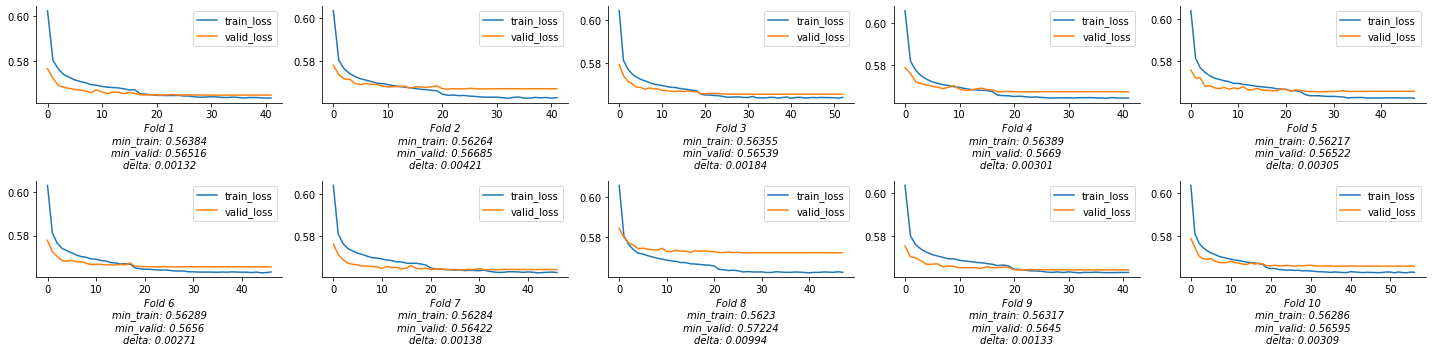

In [8]:
### plot train and valid loss over number of epochs
fig, ax = plt.subplots(2, 5, tight_layout=True, figsize=(20,5))
ax = ax.flatten()

for fold in range(cv.n_splits):
    df_eval = pd.DataFrame({'train_loss': scores[fold]['loss'], 'valid_loss': scores[fold]['val_loss']})

    min_train = np.round(np.min(df_eval['train_loss']),5)
    min_valid = np.round(np.min(df_eval['valid_loss']),5)
    delta = np.round(min_valid - min_train,5)
    
    sns.lineplot(
        x=df_eval.index,
        y=df_eval['train_loss'],
        label='train_loss',
        ax = ax[fold]
    )

    sns.lineplot(
        x=df_eval.index,
        y=df_eval['valid_loss'],
        label='valid_loss',
        ax = ax[fold]
    )
    
    ax[fold].set_ylabel('')
    ax[fold].set_xlabel(f"Fold {fold+1}\nmin_train: {min_train}\nmin_valid: {min_valid}\ndelta: {delta}", fontstyle='italic')

sns.despine()

## <span style="background:#818181;padding:0.3em;width:100%;display:block;border-radius:0.1em;color:white;font-family:Monospace">Submission</span>

In [9]:
### average predictions over each fold and create submission file
sample_submission['target'] = np.mean(np.column_stack(predictions), axis=1)
sample_submission.to_csv('./nn_baseline.csv', index=False)